# Neural Network Notebook
Main questions being answered:
1. Can the age of death based on features like gender, occupation, birth year, and associated country be predicted?
2. Can the nn accurately classify the manner of death (e.g., natural causes, accidents) based on the available features?
3. Can any non-linear relationships be discerned between occupation type and age of death or manner of death?
4. Can any outlier cases be identified / predicted, such as individuals who lived significantly longer or shorter than the average life expectancy of their associated country?
5. Can the life expectancy of a country based on the aggregate data of individuals associated with that country be predicted?
6. How well does the neural network generalize its predictions to countries or occupations that are underrepresented in the dataset?

In [36]:
# Load relevant packages
import pandas as pd
import tensorflow as tf
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


Read in the preprocessed age data from the csv file.

In [44]:
# Load the data
data = pd.read_csv('preprocessed_age.csv')

data['Gender_encoded'] = pd.factorize(data['Gender'])[0]
data['Occupation_encoded'] = pd.factorize(data['Occupation'])[0]
data['Associated Countries_encoded'] = pd.factorize(data['Associated Countries'])[0]


### Neural Network Implementation #1  
Code for the Neural Network using Keras and Tensorflow. It is a simple feedforward network with 2 hidden layers.

In [34]:
def run_neural_network(data, features, target, epochs=100, test_size=0.2, random_state=42):
    """
    Define, compile, train, and evaluate a neural network model.
    
    Parameters:
        data (DataFrame): The dataset.
        features (list): List of feature column names.
        target (str): Target column name.
        epochs (int): Number of training epochs. Default is 100.
        test_size (float): Proportion of data to be used for testing. Default is 0.2.
        random_state (int): Random state for train-test split. Default is 42.
    
    Returns:
        model: Trained neural network model.
        history: Training history of the model.
    """
    # Data Preparation
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns.tolist()),
            ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns.tolist())
        ])
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Convert the preprocessed data to dense format and then to tf.data.Dataset format
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_preprocessed.todense(), y_train)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_preprocessed.todense(), y_test)).batch(32)

    
    # Define the model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(1633,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    # Check input data shape
    print(f'Training data shape: {X_train.shape}')
    print(f'Test data shape: {X_test.shape}')

    # Check for NaN or Inf values
    print(f'NaN values in training data: {X_train.isna().sum().sum()}')
    print(f'NaN values in test data: {X_test.isna().sum().sum()}')
    print(f'Inf values in training data: {(X_train == np.inf).sum().sum()}')
    print(f'Inf values in test data: {(X_test == np.inf).sum().sum()}')

    # Display model architecture
    model.summary()
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model using tf.data.Dataset format
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs
    )
    
    # Evaluate the model
    loss, mae = model.evaluate(test_dataset)
    print(f'Mean Absolute Error on test data: {mae}')
    
    # Visualize the training process
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model, history

### Neural Network Implementation #2
Code for the NN using PyTorch.

This is the class for the Torch NN. It includes an initialiser and a forward function. The forward function is where the actual computation is done.

In [39]:
# Define the Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [47]:
def run_pytorch_nn(data, features, target, epochs=100, test_size=0.2, random_state=42):
    # Data Preparation
    X = data[features].values
    y = data[target].values.reshape(-1, 1)
    
    # Standardize the Data
    scaler_X = StandardScaler().fit(X)
    scaler_y = StandardScaler().fit(y)
    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_state)
    
    # Convert to PyTorch Tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader objects
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
    
    # Initialize Model, Loss Function, Optimizer
    model = SimpleNN(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    train_losses = []  # Store training losses for visualization
    for epoch in range(epochs):
        epoch_loss = 0  # Store cumulative loss for each epoch
        for inputs, labels in train_loader:
            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate and store average loss for the epoch
        average_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(average_epoch_loss)
        
        # Print Loss
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}')
    
    # Model Evaluation
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            prediction = model(inputs)
            test_predictions.append(prediction.numpy())
    
    # Convert predictions back to original scale
    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))

    # Visualizations
    # 1. Training Loss
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error Loss')
    plt.title('Training Loss Over Time')
    plt.show()
    
    # 2. Predictions vs. Actuals
    plt.scatter(y_test, test_predictions, alpha=0.5)
    plt.xlabel('Actual Age of Death')
    plt.ylabel('Predicted Age of Death')
    plt.title('Predictions vs. Actuals')
    plt.show()
    
    return model, test_predictions

#### Can the age of death based on features like gender, occupation, birth year, and associated country be predicted?

##### Using implmentation #1

Training data shape: (796829, 4)
Test data shape: (199208, 4)
NaN values in training data: 202485
NaN values in test data: 51020
Inf values in training data: 0
Inf values in test data: 0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                104576    
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 106689 (416.75 KB)
Trainable params: 106689 (416.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
24901/24901 [==============================] - 62s 2ms/step - loss: 260.0850 - 

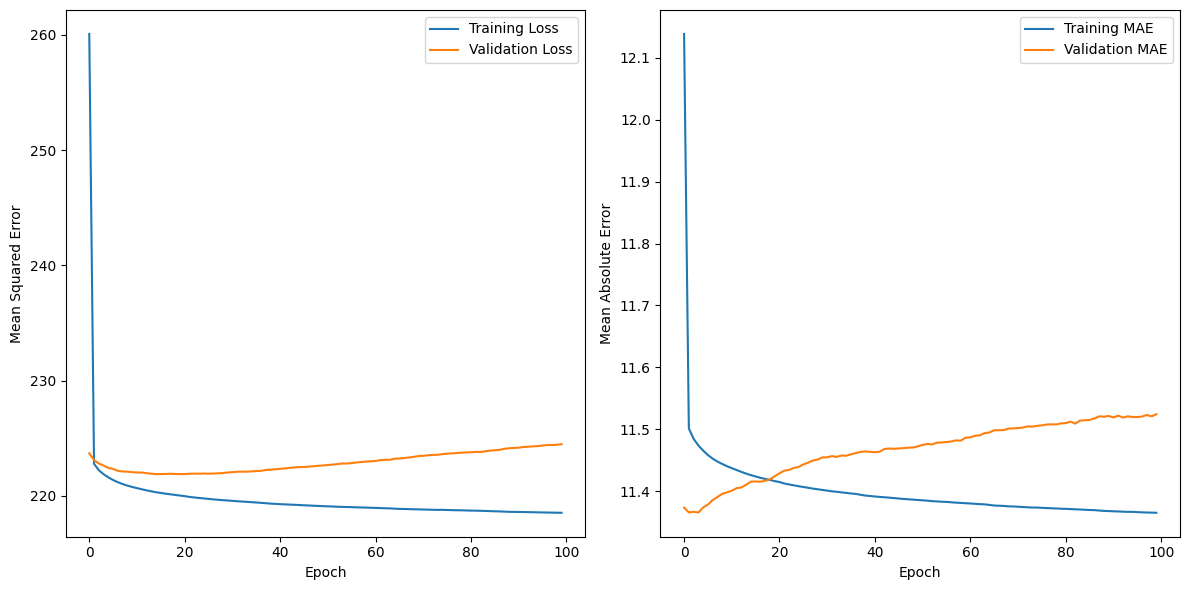

In [35]:
# Removed 'Occupation_encoded' and 'Associated Countries_encoded' from features list and moved to data preprocessing and associated countries encoded change
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'
model, history = run_neural_network(data, features, target)

##### Using implementation #2

In [48]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

model_q1_torch, predictions_q1_torch = run_pytorch_nn(data, features, target, epochs=100)


Epoch [10/100], Loss: 0.8403


##### Using implementation #3